# Autoencoder, Contastive Autoencoder and PCA for Feature Engineering

Code References:
- Data loading: https://discuss.pytorch.org/t/input-numpy-ndarray-instead-of-images-in-a-cnn/18797/3
- Train and test functions adapted from discussion sections code
- Following code for HW #6:
    - AE: https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c
    - CAE loss function: https://stackoverflow.com/questions/58249160/how-to-implement-contractive-autoencoder-in-pytorch
    

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

import librosa
import librosa.display

In [3]:
# ! pip install librosa

### 1. Autoencoder (AE)

- Encoder:
    - Four fully connected layers with 128, 64, 12 and 3 output neurons in each layer
    - First three layers use ReLU activation functions, last layer uses linear activation
- Decoder:
    - Last layer of decoder uses tanh
- Loss:
    - MSE
    
- Approximately 70% classification accuracy on MNIST (on HW Architecture)
    
Using basic code structure from https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c
    

In [5]:
# https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c
class Autoencoder(nn.Module):
    def __init__(self, in_channels):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=in_channels, out_features= 1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features= 512),
            nn.ReLU(True),
            nn.Linear(in_features=512, out_features= 256), #128
            nn.ReLU(True),
            nn.Linear(in_features=256, out_features= 128),
            nn.ReLU(True),
            nn.Linear(in_features=128, out_features= 40))
        self.decoder = nn.Sequential(             
            nn.Linear(in_features=40, out_features= 128),
            nn.ReLU(True),
            nn.Linear(in_features=128, out_features= 256),
            nn.ReLU(True),
            nn.Linear(in_features=256, out_features= 512),
            nn.ReLU(True),
            nn.Linear(in_features=512, out_features= 1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features= in_channels),
            nn.Tanh())
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

 ## 2. Contractive Autoencoder (CAE)

- can use ``Autoencoder()`` model defined above, since same architecture but different loss function
- now need to return results of encoding and decoding separately for new loss function
- Loss function implementation from https://stackoverflow.com/questions/58249160/how-to-implement-contractive-autoencoder-in-pytorch

In [6]:
class ContAutoencoder(nn.Module):
    def __init__(self, in_channels):
        super(ContAutoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=in_channels, out_features= 1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features= 512),
            nn.ReLU(True),
            nn.Linear(in_features=512, out_features= 256), #128
            nn.ReLU(True),
            nn.Linear(in_features=256, out_features= 128),
            nn.ReLU(True),
            nn.Linear(in_features=128, out_features= 40))
        self.decoder = nn.Sequential(             
            nn.Linear(in_features=40, out_features= 128),
            nn.ReLU(True),
            nn.Linear(in_features=128, out_features= 256),
            nn.ReLU(True),
            nn.Linear(in_features=256, out_features= 512),
            nn.ReLU(True),
            nn.Linear(in_features=512, out_features= 1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features= in_channels),
            nn.Tanh())
    def forward(self,x):
        h1 = self.encoder(x)
        h2 = self.decoder(h1)
        return h1, h2

In [7]:
## Function from https://stackoverflow.com/questions/58249160/how-to-implement-contractive-autoencoder-in-pytorch

def loss_function(output_e, outputs, imgs, lamda = 1e-4):

    criterion = nn.MSELoss()
    assert outputs.shape == imgs.shape ,f'outputs.shape : {outputs.shape} != imgs.shape : {imgs.shape}'
    loss1 = criterion(outputs, imgs)

    output_e.backward(torch.ones(output_e.size()), retain_graph=True)    
    # Frobenious norm, the square root of sum of all elements (absolute value)
    # in a jacobian matrix 
    loss2 = torch.sqrt(torch.sum(torch.abs(imgs.grad)))
    imgs.grad.data.zero_()
    loss = loss1 + (lamda*loss2) 
    return loss 

In [8]:
# from https://discuss.pytorch.org/t/input-numpy-ndarray-instead-of-images-in-a-cnn/18797/3

class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

### Autoencoder - Chromagram

In [6]:
## Load data
train_chroma = np.load("Data/train_chroma12.npy")
test_chroma = np.load("Data/test_chroma12.npy")
train_labels = np.load("Data/train_labels_chroma12.npy")
test_labels = np.load("Data/test_labels_chroma12.npy")

In [7]:
bs = 32

train_set = MyDataset(train_chroma, train_labels)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_set = MyDataset(test_chroma, test_labels)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [8]:
train_chroma.shape

(5366, 12, 431)

In [9]:
in_channels = train_chroma.shape[1]*train_chroma.shape[2]
model = Autoencoder(in_channels)
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [10]:
num_epochs = 10

## Training procedure from https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c        
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for data in train_loader:
        img, _ = data
        img = img.view(img.shape[0], img.shape[1]*img.shape[2])
        # ===================forward=====================
        output = model(img)
        loss = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, train_loss))

epoch [1/10], loss:159.4388
epoch [2/10], loss:151.9601
epoch [3/10], loss:144.7642
epoch [4/10], loss:139.9030
epoch [5/10], loss:137.9957
epoch [6/10], loss:136.2091
epoch [7/10], loss:134.7196
epoch [8/10], loss:133.6832
epoch [9/10], loss:133.0403
epoch [10/10], loss:131.8335


In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [12]:
chroma_mean = 0.2806374888288301
chroma_sd = 0.29424393073518096

In [13]:
enc_output = model.encoder(images.view(images.shape[0], images.shape[1]*images.shape[2]))
dec_output = model.decoder(enc_output).view(images.shape[0], images.shape[1], images.shape[2])

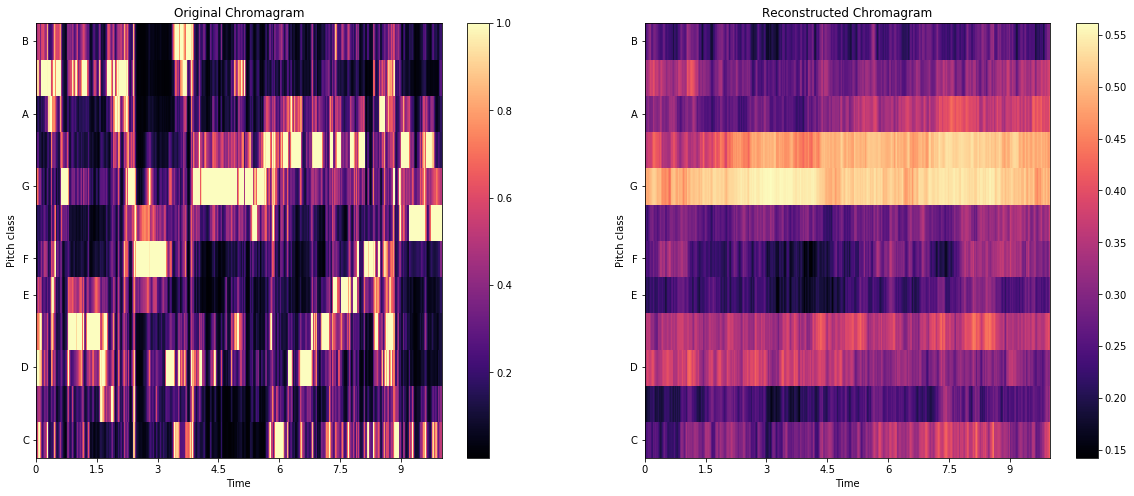

In [14]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(chroma_sd*images[3,:,:].detach().numpy() + chroma_mean, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title("Original Chromagram")
plt.subplot(1,2,2)
librosa.display.specshow(chroma_sd*dec_output[3,:,:].detach().numpy() + chroma_mean, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title("Reconstructed Chromagram")
pass

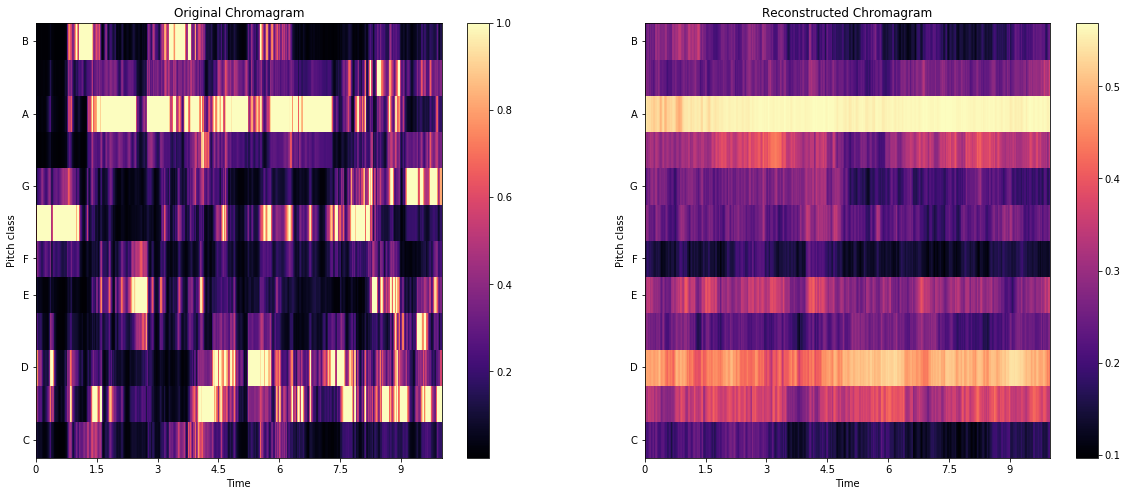

In [15]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(chroma_sd*images[7,:,:].detach().numpy()+chroma_mean, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title("Original Chromagram")
plt.subplot(1,2,2)
librosa.display.specshow(chroma_sd*dec_output[7,:,:].detach().numpy()+chroma_mean, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title("Reconstructed Chromagram")
pass

### Extract Features for Classification

In [17]:
AE_train_features = torch.zeros(1, 40)
for batch_idx, (data, target) in enumerate(train_loader):
    img = data.view(data.shape[0], data.shape[1]*data.shape[2])
    enc_output = model.encoder(img)
    AE_train_features = torch.cat((AE_train_features, enc_output), 0)
    
    if batch_idx == 0:
        AE_train_labels = target
    else:
        AE_train_labels = torch.cat((AE_train_labels, target), 0)

In [18]:
train_chroma.shape

(5366, 12, 431)

In [19]:
AE_train_features = AE_train_features[1:, :]
AE_train_features.shape

torch.Size([5366, 40])

In [20]:
model.decoder(AE_train_features).shape

torch.Size([5366, 5172])

In [21]:
decoded = model.decoder(AE_train_features).view(5366, images.shape[1], images.shape[2])

In [22]:
AE_test_features = torch.zeros(1, 40)

for batch_idx, (data, target) in enumerate(test_loader):
    img = data.view(data.shape[0], data.shape[1]*data.shape[2])
    enc_output = model.encoder(img)
    AE_test_features = torch.cat((AE_test_features, enc_output), 0)
    if batch_idx == 0:
        AE_test_labels = target
    else:
        AE_test_labels = torch.cat((AE_test_labels, target), 0)

In [23]:
AE_test_features = AE_test_features[1:, :]
AE_test_features.shape

torch.Size([3842, 40])

In [24]:
model.decoder(AE_test_features).shape

torch.Size([3842, 5172])

In [25]:
decoded_test = model.decoder(AE_test_features).view(3842, images.shape[1], images.shape[2])

In [26]:
AE_train_features = AE_train_features.detach().numpy()
AE_test_features = AE_test_features.detach().numpy()
AE_train_labels = AE_train_labels.numpy()
AE_test_labels = AE_test_labels.numpy()

In [27]:
## Classify via logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [28]:
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                        max_iter = 1000).fit(X=AE_train_features, y=AE_train_labels)

In [29]:
## Training Accuracy
y_pred = clf.predict(AE_train_features)
AE_train_acc = metrics.accuracy_score(AE_train_labels, y_pred)
AE_train_acc

0.43868803578084237

In [30]:
## Test Accuracy
y_pred = clf.predict(AE_test_features)
AE_test_acc = metrics.accuracy_score(AE_test_labels, y_pred)
AE_test_acc

0.39432587194169705

### CAE - Chromagram

In [31]:
in_channels = train_chroma.shape[1]*train_chroma.shape[2]
model = ContAutoencoder(in_channels)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)


In [32]:
## Training loop format also from 
## https://stackoverflow.com/questions/58249160/how-to-implement-contractive-autoencoder-in-pytorch
num_epochs = 10

for epoch in range(num_epochs):
    for i, (img, labels) in enumerate(train_loader):
        img = img.view(img.shape[0], img.shape[1]*img.shape[2])
        
        img.retain_grad()
        img.requires_grad_(True)

        outputs_encode, outputs_decode = model(img)
#         outputs_decode = outputs_decode.view(bs, images.shape[1], images.shape[2], images.shape[3])
        loss = loss_function(outputs_encode, outputs_decode, img, 1e-4)

        img.requires_grad_(False)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch/epochs: {epoch}/{num_epochs} loss: {loss.item():.4f}')

epoch/epochs: 0/10 loss: 0.9090
epoch/epochs: 1/10 loss: 0.8892
epoch/epochs: 2/10 loss: 0.8530
epoch/epochs: 3/10 loss: 0.7853
epoch/epochs: 4/10 loss: 0.8296
epoch/epochs: 5/10 loss: 0.7806
epoch/epochs: 6/10 loss: 0.7965
epoch/epochs: 7/10 loss: 0.7775
epoch/epochs: 8/10 loss: 0.7961
epoch/epochs: 9/10 loss: 0.7731


In [33]:
## Extract features

CAE_train_features = torch.zeros(1, 40)

for batch_idx, (data, target) in enumerate(train_loader):
    img = data.view(data.shape[0], data.shape[1]*data.shape[2])
    enc_output = model.encoder(img)
    CAE_train_features = torch.cat((CAE_train_features, enc_output), 0)
    
    if batch_idx == 0:
        CAE_train_labels = target
    else:
        CAE_train_labels = torch.cat((CAE_train_labels, target), 0)

In [34]:
CAE_train_features = CAE_train_features[1:, :]
CAE_train_features.shape

torch.Size([5366, 40])

In [35]:
decoded = model.decoder(CAE_train_features).view(5366, images.shape[1], images.shape[2])

In [36]:
CAE_test_features = torch.zeros(1, 40)

for batch_idx, (data, target) in enumerate(test_loader):
    img = data.view(data.shape[0], data.shape[1]*data.shape[2])
    enc_output = model.encoder(img)
    CAE_test_features = torch.cat((CAE_test_features, enc_output), 0)
    if batch_idx == 0:
        CAE_test_labels = target
    else:
        CAE_test_labels = torch.cat((CAE_test_labels, target), 0)

In [37]:
CAE_test_features = CAE_test_features[1:, :]
CAE_test_features.shape

torch.Size([3842, 40])

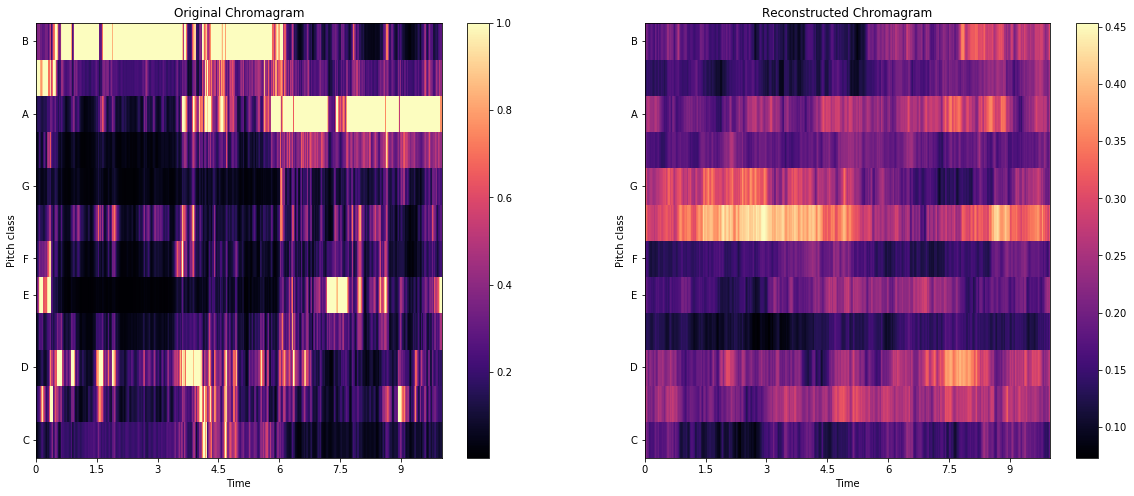

In [38]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(chroma_sd*train_chroma[3,:,:] + chroma_mean, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title("Original Chromagram")
plt.subplot(1,2,2)
librosa.display.specshow(chroma_sd*decoded[3,:,:].detach().numpy() + chroma_mean, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title("Reconstructed Chromagram")
pass

In [39]:
CAE_train_features = CAE_train_features.detach().numpy()
CAE_test_features = CAE_test_features.detach().numpy()
CAE_train_labels = CAE_train_labels.numpy()
CAE_test_labels = CAE_test_labels.numpy()

In [40]:
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                        max_iter = 1000).fit(X=CAE_train_features, y=CAE_train_labels)

## Training Accuracy
y_pred = clf.predict(CAE_train_features)
CAE_train_acc = metrics.accuracy_score(CAE_train_labels, y_pred)
CAE_train_acc

0.4476332463660082

In [41]:
## Test Accuracy
y_pred = clf.predict(CAE_test_features)
CAE_test_acc = metrics.accuracy_score(CAE_test_labels, y_pred)
CAE_test_acc

0.4060385216033316

### 3. PCA - Chromagram

In [42]:
## Extract features to numpy

for batch_idx, (data, target) in enumerate(train_loader):
    data = data.view(data.shape[0], data.shape[1]*data.shape[2])
    if batch_idx == 0:
        X_train = data
        train_label = target
    else:
        X_train = torch.cat((X_train, data))
        train_label = torch.cat((train_label, target))
        
for batch_idx, (data, target) in enumerate(test_loader):
    data = data.view(data.shape[0], data.shape[1]*data.shape[2])
    if batch_idx == 0:
        X_test = data
        test_label = target
    else:
        X_test = torch.cat((X_test, data))
        test_label = torch.cat((test_label, target))

In [43]:
X_train = X_train.numpy()
X_test = X_test.numpy()

train_label = train_label.numpy()
test_label = test_label.numpy()

In [44]:
from sklearn.decomposition import PCA

# Fit the PCA model to the training set(MNIST)
pca = PCA(n_components = 40).fit(X_train)

# Encoded training values and test values
encoded_train_pca = pca.fit_transform(X_train)
encoded_test_pca = pca.fit_transform(X_test)

## Logistic Regression to Classify

In [45]:
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                        max_iter = 1000).fit(X=encoded_train_pca, y=train_label)

In [46]:
## Training Accuracy
y_pred = clf.predict(encoded_train_pca)
pca_train_acc = metrics.accuracy_score(train_label, y_pred)
pca_train_acc

0.4198658218412225

In [47]:
## Test Accuracy
y_pred = clf.predict(encoded_test_pca)
pca_test_acc = metrics.accuracy_score(test_label, y_pred)
pca_test_acc

0.3589276418532015

## MFCC - 13

In [48]:
## Load data
train_mfcc = np.load("Data/train_mfcc13.npy")
test_mfcc = np.load("Data/test_mfcc13.npy")
train_labels = np.load("Data/train_labels_mfcc13.npy")
test_labels = np.load("Data/test_labels_mfcc13.npy")

In [49]:
bs = 32
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((np.mean(train_mfcc),), (np.std(train_mfcc),))]) ## (1) mean and (2) sd 

train_set_mfcc = MyDataset(train_mfcc, train_labels)
train_loader_mfcc = DataLoader(train_set_mfcc, batch_size=32, shuffle=True)
test_set_mfcc = MyDataset(test_mfcc, test_labels)
test_loader_mfcc = DataLoader(test_set_mfcc, batch_size=32, shuffle=False)

### AE

In [50]:
# https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c
class Autoencoder(nn.Module):
    def __init__(self, in_channels):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=in_channels, out_features= 1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features= 512),
            nn.ReLU(True),
            nn.Linear(in_features=512, out_features= 256), #128
            nn.ReLU(True),
            nn.Linear(in_features=256, out_features= 128),
            nn.ReLU(True),
            nn.Linear(in_features=128, out_features= 40))
        self.decoder = nn.Sequential(             
            nn.Linear(in_features=40, out_features= 128),
            nn.ReLU(True),
            nn.Linear(in_features=128, out_features= 256),
            nn.ReLU(True),
            nn.Linear(in_features=256, out_features= 512),
            nn.ReLU(True),
            nn.Linear(in_features=512, out_features= 1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features= in_channels),
            nn.Tanh())
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [51]:
in_channels = train_mfcc.shape[1]*train_mfcc.shape[2]
model = Autoencoder(in_channels)
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [52]:
num_epochs = 10

## Training procedure from https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c        
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for data in train_loader_mfcc:
        img, _ = data
        img = img.view(img.shape[0], img.shape[1]*img.shape[2])
        # ===================forward=====================
        output = model(img)
        loss = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, train_loss))

epoch [1/10], loss:78.8317
epoch [2/10], loss:75.3283
epoch [3/10], loss:75.0783
epoch [4/10], loss:75.1107
epoch [5/10], loss:75.0820
epoch [6/10], loss:75.1433
epoch [7/10], loss:74.9792
epoch [8/10], loss:75.0080
epoch [9/10], loss:74.9363
epoch [10/10], loss:74.9233


In [53]:
dataiter = iter(train_loader_mfcc)
images, labels = dataiter.next()

In [54]:
enc_output = model.encoder(images.view(images.shape[0], images.shape[1]*images.shape[2]))
dec_output = model.decoder(enc_output).view(images.shape[0], images.shape[1], images.shape[2])

In [55]:
mean_mfcc = -15.351313770438622
std_mfcc = 104.4164497835367

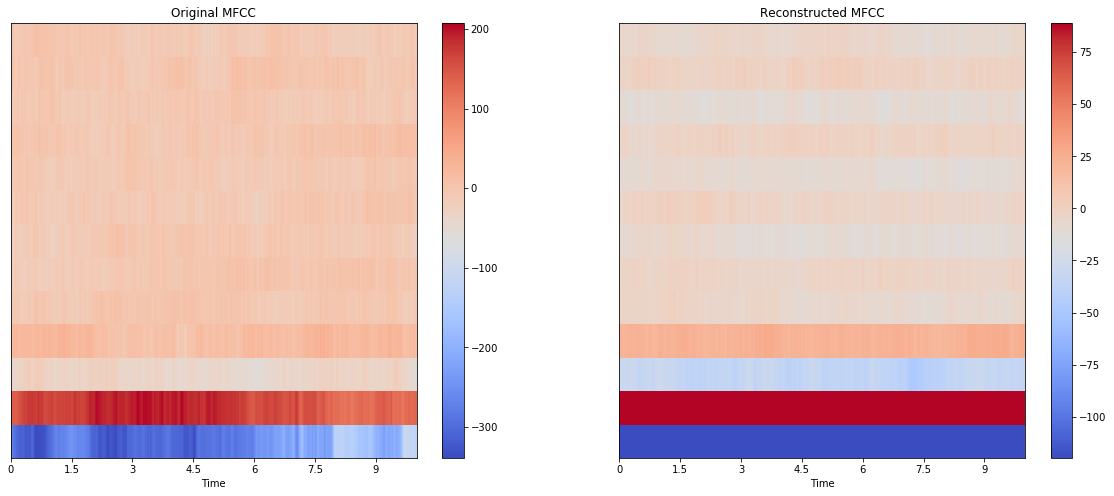

In [56]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(std_mfcc*images[3,:,:].detach().numpy() + mean_mfcc, x_axis='time')
plt.colorbar()
plt.title("Original MFCC")
plt.subplot(1,2,2)
librosa.display.specshow(std_mfcc*dec_output[3,:,:].detach().numpy() + mean_mfcc,  x_axis='time')
plt.colorbar()
plt.title("Reconstructed MFCC")
pass

In [57]:
AE_train_features = torch.zeros(1, 40)
for batch_idx, (data, target) in enumerate(train_loader_mfcc):
    img = data.view(data.shape[0], data.shape[1]*data.shape[2])
    enc_output = model.encoder(img)
    AE_train_features = torch.cat((AE_train_features, enc_output), 0)
    
    if batch_idx == 0:
        AE_train_labels = target
    else:
        AE_train_labels = torch.cat((AE_train_labels, target), 0)

In [58]:
AE_train_features = AE_train_features[1:, :]
AE_train_features.shape

torch.Size([5366, 40])

In [59]:
decoded = model.decoder(AE_train_features).view(5366, images.shape[1], images.shape[2])

In [60]:
AE_test_features = torch.zeros(1, 40)

for batch_idx, (data, target) in enumerate(test_loader_mfcc):
    img = data.view(data.shape[0], data.shape[1]*data.shape[2])
    enc_output = model.encoder(img)
    AE_test_features = torch.cat((AE_test_features, enc_output), 0)
    if batch_idx == 0:
        AE_test_labels = target
    else:
        AE_test_labels = torch.cat((AE_test_labels, target), 0)

In [61]:
AE_test_features = AE_test_features[1:, :]
AE_test_features.shape

torch.Size([3842, 40])

In [62]:
decoded_test = model.decoder(AE_test_features).view(3842, images.shape[1], images.shape[2])

In [63]:
AE_train_features = AE_train_features.detach().numpy()
AE_test_features = AE_test_features.detach().numpy()
AE_train_labels = AE_train_labels.numpy()
AE_test_labels = AE_test_labels.numpy()

In [29]:
## Classify via logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [65]:
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                        max_iter = 5000).fit(X=AE_train_features, y=AE_train_labels)

In [66]:
## Training Accuracy
y_pred = clf.predict(AE_train_features)
AE_train_acc = metrics.accuracy_score(AE_train_labels, y_pred)
AE_train_acc

0.3963846440551621

In [67]:
## Test Accuracy
y_pred = clf.predict(AE_test_features)
AE_test_acc = metrics.accuracy_score(AE_test_labels, y_pred)
AE_test_acc

0.39406559083810516

### CAE - MFCC

In [68]:
in_channels = train_mfcc.shape[1]*train_mfcc.shape[2]
model = ContAutoencoder(in_channels)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)


In [70]:
## Training loop format also from 
## https://stackoverflow.com/questions/58249160/how-to-implement-contractive-autoencoder-in-pytorch
num_epochs = 10

for epoch in range(num_epochs):
    for i, (img, labels) in enumerate(train_loader_mfcc):
        img = img.view(img.shape[0], img.shape[1]*img.shape[2])
        
        img.retain_grad()
        img.requires_grad_(True)

        outputs_encode, outputs_decode = model(img)
#         outputs_decode = outputs_decode.view(bs, images.shape[1], images.shape[2], images.shape[3])
        loss = loss_function(outputs_encode, outputs_decode, img, 1e-4)

        img.requires_grad_(False)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch/epochs: {epoch}/{num_epochs} loss: {loss.item():.4f}')

epoch/epochs: 0/10 loss: 0.3552
epoch/epochs: 1/10 loss: 0.5924
epoch/epochs: 2/10 loss: 0.5063
epoch/epochs: 3/10 loss: 0.4315
epoch/epochs: 4/10 loss: 0.5162
epoch/epochs: 5/10 loss: 0.4235
epoch/epochs: 6/10 loss: 0.6963
epoch/epochs: 7/10 loss: 0.3950
epoch/epochs: 8/10 loss: 0.4356
epoch/epochs: 9/10 loss: 0.4877


In [71]:
## Extract features

CAE_train_features = torch.zeros(1, 40)

for batch_idx, (data, target) in enumerate(train_loader_mfcc):
    img = data.view(data.shape[0], data.shape[1]*data.shape[2])
    enc_output = model.encoder(img)
    CAE_train_features = torch.cat((CAE_train_features, enc_output), 0)
    
    if batch_idx == 0:
        CAE_train_labels = target
    else:
        CAE_train_labels = torch.cat((CAE_train_labels, target), 0)

In [72]:
CAE_train_features = CAE_train_features[1:, :]
CAE_train_features.shape

torch.Size([5366, 40])

In [73]:
decoded = model.decoder(CAE_train_features).view(5366, images.shape[1], images.shape[2])

In [74]:
CAE_test_features = torch.zeros(1, 40)

for batch_idx, (data, target) in enumerate(test_loader_mfcc):
    img = data.view(data.shape[0], data.shape[1]*data.shape[2])
    enc_output = model.encoder(img)
    CAE_test_features = torch.cat((CAE_test_features, enc_output), 0)
    if batch_idx == 0:
        CAE_test_labels = target
    else:
        CAE_test_labels = torch.cat((CAE_test_labels, target), 0)

In [75]:
CAE_test_features = CAE_test_features[1:, :]
CAE_test_features.shape

torch.Size([3842, 40])

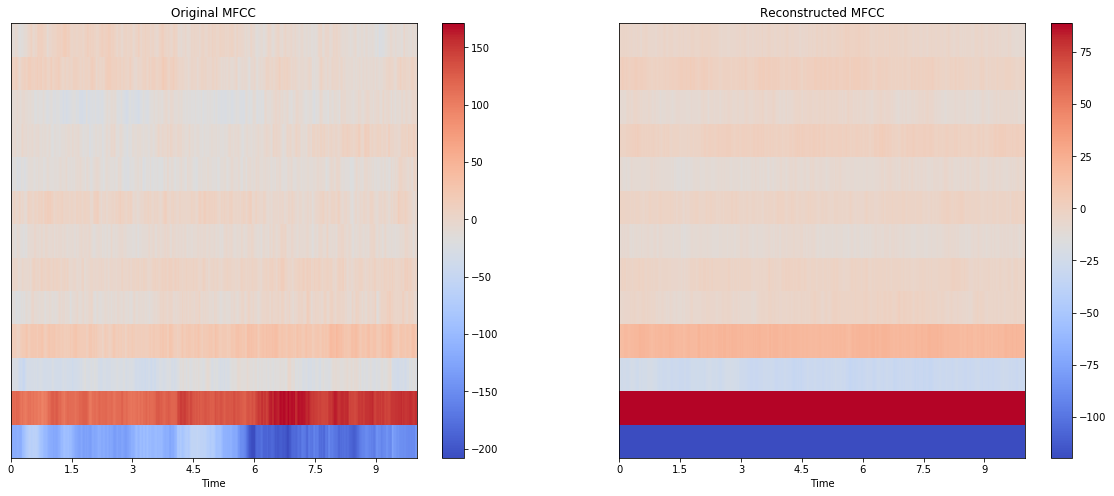

In [76]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(std_mfcc*train_mfcc[3,:,:] + mean_mfcc, x_axis='time')
plt.colorbar()
plt.title("Original MFCC")
plt.subplot(1,2,2)
librosa.display.specshow(std_mfcc*decoded[3,:,:].detach().numpy() + mean_mfcc, x_axis='time')
plt.colorbar()
plt.title("Reconstructed MFCC")
pass

In [77]:
CAE_train_features = CAE_train_features.detach().numpy()
CAE_test_features = CAE_test_features.detach().numpy()
CAE_train_labels = CAE_train_labels.numpy()
CAE_test_labels = CAE_test_labels.numpy()

In [78]:
clf = LogisticRegression(multi_class='multinomial', solver='saga',
                        max_iter = 1000).fit(X=CAE_train_features, y=CAE_train_labels)

## Training Accuracy
y_pred = clf.predict(CAE_train_features)
CAE_train_acc = metrics.accuracy_score(CAE_train_labels, y_pred)
CAE_train_acc

0.3689899366380917

In [79]:
## Test Accuracy
y_pred = clf.predict(CAE_test_features)
CAE_test_acc = metrics.accuracy_score(CAE_test_labels, y_pred)
CAE_test_acc

0.36647579385736595

### PCA

In [80]:
## Extract features to numpy

for batch_idx, (data, target) in enumerate(train_loader_mfcc):
    data = data.view(data.shape[0], data.shape[1]*data.shape[2])
    if batch_idx == 0:
        X_train = data
        train_label = target
    else:
        X_train = torch.cat((X_train, data))
        train_label = torch.cat((train_label, target))
        
for batch_idx, (data, target) in enumerate(test_loader_mfcc):
    data = data.view(data.shape[0], data.shape[1]*data.shape[2])
    if batch_idx == 0:
        X_test = data
        test_label = target
    else:
        X_test = torch.cat((X_test, data))
        test_label = torch.cat((test_label, target))

In [81]:
X_train = X_train.numpy()
X_test = X_test.numpy()

train_label = train_label.numpy()
test_label = test_label.numpy()

In [82]:
from sklearn.decomposition import PCA

# Fit the PCA model to the training set(MNIST)
pca = PCA(n_components = 40).fit(X_train)

# Encoded training values and test values
encoded_train_pca = pca.fit_transform(X_train)
encoded_test_pca = pca.fit_transform(X_test)

In [83]:
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                        max_iter = 1000).fit(X=encoded_train_pca, y=train_label)

In [84]:
## Training Accuracy
y_pred = clf.predict(encoded_train_pca)
pca_train_acc = metrics.accuracy_score(train_label, y_pred)
pca_train_acc

0.5450987700335446

In [85]:
## Test Accuracy
y_pred = clf.predict(encoded_test_pca)
pca_test_acc = metrics.accuracy_score(test_label, y_pred)
pca_test_acc

0.34903695991671

## Spectrograms

In [9]:
## Load data

train_stft1 = np.load("Data/train_stft-dB-1.npy", allow_pickle = True)
test_stft1 = np.load("Data/test_stft-dB-1.npy")
train_labels1 = np.load("Data/train_labels_stft-dB-1.npy")
test_labels1 = np.load("Data/test_labels_stft-dB-1.npy")

## Load new data
train_stft2 = np.load("Data/train_stft-dB-2.npy", allow_pickle = True)
test_stft2 = np.load("Data/test_stft-dB-2.npy")
train_labels2 = np.load("Data/train_labels_stft-dB-2.npy")
test_labels2 = np.load("Data/test_labels_stft-dB-2.npy")


In [10]:
train_stft = np.concatenate((train_stft1, train_stft2))
test_stft = np.concatenate((test_stft1, test_stft2))
train_labels = np.concatenate((train_labels1, train_labels2))
test_labels = np.concatenate((test_labels1, test_labels2))

bs = 32

train_set = MyDataset(train_stft, train_labels)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_set = MyDataset(test_stft, test_labels)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)

### AE

In [12]:
in_channels = train_stft.shape[1]*train_stft.shape[2]
model = Autoencoder(in_channels)
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [13]:
num_epochs = 10

## Training procedure from https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c        
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for data in train_loader:
        img, _ = data
        img = img.view(img.shape[0], img.shape[1]*img.shape[2])
        # ===================forward=====================
        output = model(img)
        loss = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, train_loss))

epoch [1/10], loss:33.1979
epoch [2/10], loss:25.9724
epoch [3/10], loss:25.4712
epoch [4/10], loss:24.0764
epoch [5/10], loss:22.3101
epoch [6/10], loss:21.7448
epoch [7/10], loss:21.5933
epoch [8/10], loss:21.5991
epoch [9/10], loss:21.8000
epoch [10/10], loss:21.7033


In [14]:
## Load new data
train_stft1 = np.load("Data/train_stft-dB-3.npy", allow_pickle = True)
test_stft1 = np.load("Data/test_stft-dB-3.npy")
train_labels1 = np.load("Data/train_labels_stft-dB-3.npy")
test_labels1 = np.load("Data/test_labels_stft-dB-3.npy")

train_stft2 = np.load("Data/train_stft-dB-4.npy", allow_pickle = True)
test_stft2 = np.load("Data/test_stft-dB-4.npy")
train_labels2 = np.load("Data/train_labels_stft-dB-4.npy")
test_labels2 = np.load("Data/test_labels_stft-dB-4.npy")

train_stft = np.concatenate((train_stft1, train_stft2))
test_stft = np.concatenate((test_stft1, test_stft2))
train_labels = np.concatenate((train_labels1, train_labels2))
test_labels = np.concatenate((test_labels1, test_labels2))


train_set = MyDataset(train_stft, train_labels)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_set = MyDataset(test_stft, test_labels)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [15]:
num_epochs = 10

## Training procedure from https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c        
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for data in train_loader:
        img, _ = data
        img = img.view(img.shape[0], img.shape[1]*img.shape[2])
        # ===================forward=====================
        output = model(img)
        loss = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, train_loss))

epoch [1/10], loss:21.1090
epoch [2/10], loss:21.2322
epoch [3/10], loss:20.9297
epoch [4/10], loss:20.9058
epoch [5/10], loss:20.9743
epoch [6/10], loss:20.9534
epoch [7/10], loss:21.0180
epoch [8/10], loss:20.9365
epoch [9/10], loss:20.7666
epoch [10/10], loss:20.7589


In [16]:
## Load new data
train_stft = np.load("Data/train_stft-dB-5.npy", allow_pickle = True)
test_stft = np.load("Data/test_stft-dB-5.npy")
train_labels = np.load("Data/train_labels_stft-dB-5.npy")
test_labels = np.load("Data/test_labels_stft-dB-5.npy")


bs = 32

train_set = MyDataset(train_stft, train_labels)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_set = MyDataset(test_stft, test_labels)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [17]:
num_epochs = 10

## Training procedure from https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c        
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for data in train_loader:
        img, _ = data
        img = img.view(img.shape[0], img.shape[1]*img.shape[2])
        # ===================forward=====================
        output = model(img)
        loss = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, train_loss))

epoch [1/10], loss:10.5080
epoch [2/10], loss:10.2440
epoch [3/10], loss:10.0505
epoch [4/10], loss:10.0500
epoch [5/10], loss:9.9017
epoch [6/10], loss:9.8216
epoch [7/10], loss:9.7322
epoch [8/10], loss:9.7163
epoch [9/10], loss:9.7239
epoch [10/10], loss:9.6862


In [18]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [19]:
enc_output = model.encoder(images.view(images.shape[0], images.shape[1]*images.shape[2]))
dec_output = model.decoder(enc_output).view(images.shape[0], images.shape[1], images.shape[2])

In [20]:
sr = 22050
stft_mean = -39.25553443598964
stft_sd = 16.763774999817553

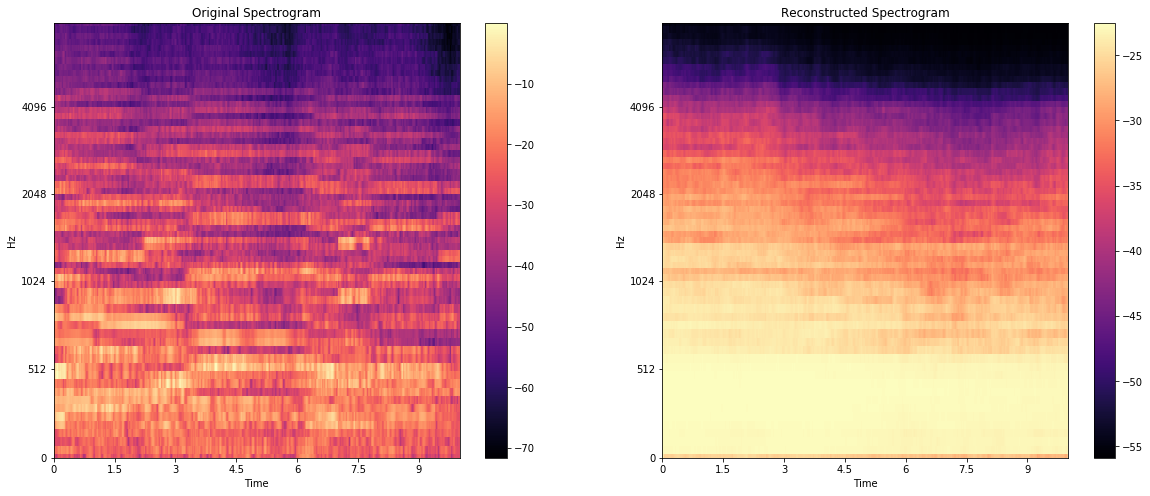

In [21]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(stft_sd*images[0,:,:].detach().numpy() + stft_mean, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar()
plt.title("Original Spectrogram")
plt.subplot(1,2,2)
librosa.display.specshow(stft_sd*dec_output[0,:,:].detach().numpy() + stft_mean,  x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar()
plt.title("Reconstructed Spectrogram")
pass

In [22]:
dec_output[3,:,:]

tensor([[ 0.5789,  0.4738,  0.2905,  ..., -0.2155, -0.1957, -0.1541],
        [ 0.7859,  0.7922,  0.7785,  ..., -0.2021, -0.1997, -0.0641],
        [ 0.8210,  0.8200,  0.8183,  ..., -0.0928, -0.1166, -0.0487],
        ...,
        [-0.9944, -0.9953, -0.9953,  ..., -0.9997, -0.9997, -0.9997],
        [-0.9972, -0.9958, -0.9948,  ..., -0.9997, -0.9997, -0.9997],
        [-0.9967, -0.9976, -0.9970,  ..., -0.9998, -0.9998, -0.9998]],
       grad_fn=<SliceBackward>)

In [23]:
AE_train_features = torch.zeros(1, 40)
for batch_idx, (data, target) in enumerate(train_loader):
    img = data.view(data.shape[0], data.shape[1]*data.shape[2])
    enc_output = model.encoder(img)
    AE_train_features = torch.cat((AE_train_features, enc_output), 0)
    
    if batch_idx == 0:
        AE_train_labels = target
    else:
        AE_train_labels = torch.cat((AE_train_labels, target), 0)

In [24]:
AE_train_features = AE_train_features[1:, :]
AE_train_features.shape

torch.Size([1073, 40])

In [25]:
AE_test_features = torch.zeros(1, 40)

for batch_idx, (data, target) in enumerate(test_loader):
    img = data.view(data.shape[0], data.shape[1]*data.shape[2])
    enc_output = model.encoder(img)
    AE_test_features = torch.cat((AE_test_features, enc_output), 0)
    if batch_idx == 0:
        AE_test_labels = target
    else:
        AE_test_labels = torch.cat((AE_test_labels, target), 0)

In [26]:
AE_test_features = AE_test_features[1:, :]
AE_test_features.shape

torch.Size([768, 40])

In [27]:
AE_train_features = AE_train_features.detach().numpy()
AE_test_features = AE_test_features.detach().numpy()
AE_train_labels = AE_train_labels.numpy()
AE_test_labels = AE_test_labels.numpy()

In [30]:
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                        max_iter = 5000).fit(X=AE_train_features, y=AE_train_labels)

In [31]:
## Training Accuracy
y_pred = clf.predict(AE_train_features)
AE_train_acc = metrics.accuracy_score(AE_train_labels, y_pred)
AE_train_acc

0.3895619757688723

In [32]:
## Test Accuracy
y_pred = clf.predict(AE_test_features)
AE_test_acc = metrics.accuracy_score(AE_test_labels, y_pred)
AE_test_acc

0.34765625

### CAE

In [34]:
in_channels = train_stft.shape[1]*train_stft.shape[2]
model = ContAutoencoder(in_channels)
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [35]:
## Load data

train_stft1 = np.load("Data/train_stft-dB-1.npy", allow_pickle = True)
test_stft1 = np.load("Data/test_stft-dB-1.npy")
train_labels1 = np.load("Data/train_labels_stft-dB-1.npy")
test_labels1 = np.load("Data/test_labels_stft-dB-1.npy")

## Load new data
train_stft2 = np.load("Data/train_stft-dB-2.npy", allow_pickle = True)
test_stft2 = np.load("Data/test_stft-dB-2.npy")
train_labels2 = np.load("Data/train_labels_stft-dB-2.npy")
test_labels2 = np.load("Data/test_labels_stft-dB-2.npy")


In [36]:
train_stft = np.concatenate((train_stft1, train_stft2))
test_stft = np.concatenate((test_stft1, test_stft2))
train_labels = np.concatenate((train_labels1, train_labels2))
test_labels = np.concatenate((test_labels1, test_labels2))

bs = 32

train_set = MyDataset(train_stft, train_labels)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_set = MyDataset(test_stft, test_labels)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [37]:
## Training loop format also from 
## https://stackoverflow.com/questions/58249160/how-to-implement-contractive-autoencoder-in-pytorch
num_epochs = 10

for epoch in range(num_epochs):
    for i, (img, labels) in enumerate(train_loader):
        img = img.view(img.shape[0], img.shape[1]*img.shape[2])
        
        img.retain_grad()
        img.requires_grad_(True)

        outputs_encode, outputs_decode = model(img)
#         outputs_decode = outputs_decode.view(bs, images.shape[1], images.shape[2], images.shape[3])
        loss = loss_function(outputs_encode, outputs_decode, img, 1e-4)

        img.requires_grad_(False)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch/epochs: {epoch}/{num_epochs} loss: {loss.item():.4f}')

epoch/epochs: 0/10 loss: 0.3602
epoch/epochs: 1/10 loss: 0.2932
epoch/epochs: 2/10 loss: 0.3761
epoch/epochs: 3/10 loss: 0.4478
epoch/epochs: 4/10 loss: 0.3262
epoch/epochs: 5/10 loss: 0.3093
epoch/epochs: 6/10 loss: 0.2451
epoch/epochs: 7/10 loss: 0.2048
epoch/epochs: 8/10 loss: 0.2542
epoch/epochs: 9/10 loss: 0.2705


In [38]:
## Load new data
train_stft1 = np.load("Data/train_stft-dB-3.npy", allow_pickle = True)
test_stft1 = np.load("Data/test_stft-dB-3.npy")
train_labels1 = np.load("Data/train_labels_stft-dB-3.npy")
test_labels1 = np.load("Data/test_labels_stft-dB-3.npy")

train_stft2 = np.load("Data/train_stft-dB-4.npy", allow_pickle = True)
test_stft2 = np.load("Data/test_stft-dB-4.npy")
train_labels2 = np.load("Data/train_labels_stft-dB-4.npy")
test_labels2 = np.load("Data/test_labels_stft-dB-4.npy")

train_stft = np.concatenate((train_stft1, train_stft2))
test_stft = np.concatenate((test_stft1, test_stft2))
train_labels = np.concatenate((train_labels1, train_labels2))
test_labels = np.concatenate((test_labels1, test_labels2))

bs = 32

train_set = MyDataset(train_stft, train_labels)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_set = MyDataset(test_stft, test_labels)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [39]:
## Training loop format also from 
## https://stackoverflow.com/questions/58249160/how-to-implement-contractive-autoencoder-in-pytorch
num_epochs = 10

for epoch in range(num_epochs):
    for i, (img, labels) in enumerate(train_loader):
        img = img.view(img.shape[0], img.shape[1]*img.shape[2])
        
        img.retain_grad()
        img.requires_grad_(True)

        outputs_encode, outputs_decode = model(img)
#         outputs_decode = outputs_decode.view(bs, images.shape[1], images.shape[2], images.shape[3])
        loss = loss_function(outputs_encode, outputs_decode, img, 1e-4)

        img.requires_grad_(False)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch/epochs: {epoch}/{num_epochs} loss: {loss.item():.4f}')

epoch/epochs: 0/10 loss: 0.2764
epoch/epochs: 1/10 loss: 0.1792
epoch/epochs: 2/10 loss: 0.3304
epoch/epochs: 3/10 loss: 0.2357
epoch/epochs: 4/10 loss: 0.2932
epoch/epochs: 5/10 loss: 0.4248
epoch/epochs: 6/10 loss: 0.3770
epoch/epochs: 7/10 loss: 0.3622
epoch/epochs: 8/10 loss: 0.5553
epoch/epochs: 9/10 loss: 0.1570


In [40]:
## Load new data
train_stft = np.load("Data/train_stft-dB-5.npy", allow_pickle = True)
test_stft = np.load("Data/test_stft-dB-5.npy")
train_labels = np.load("Data/train_labels_stft-dB-5.npy")
test_labels = np.load("Data/test_labels_stft-dB-5.npy")


bs = 32

train_set = MyDataset(train_stft, train_labels)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_set = MyDataset(test_stft, test_labels)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [41]:
## Training loop format also from 
## https://stackoverflow.com/questions/58249160/how-to-implement-contractive-autoencoder-in-pytorch
num_epochs = 10

for epoch in range(num_epochs):
    for i, (img, labels) in enumerate(train_loader):
        img = img.view(img.shape[0], img.shape[1]*img.shape[2])
        
        img.retain_grad()
        img.requires_grad_(True)

        outputs_encode, outputs_decode = model(img)
#         outputs_decode = outputs_decode.view(bs, images.shape[1], images.shape[2], images.shape[3])
        loss = loss_function(outputs_encode, outputs_decode, img, 1e-4)

        img.requires_grad_(False)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch/epochs: {epoch}/{num_epochs} loss: {loss.item():.4f}')

epoch/epochs: 0/10 loss: 0.3230
epoch/epochs: 1/10 loss: 0.2838
epoch/epochs: 2/10 loss: 0.3558
epoch/epochs: 3/10 loss: 0.3861
epoch/epochs: 4/10 loss: 0.2990
epoch/epochs: 5/10 loss: 0.2797
epoch/epochs: 6/10 loss: 0.3059
epoch/epochs: 7/10 loss: 0.2455
epoch/epochs: 8/10 loss: 0.2690
epoch/epochs: 9/10 loss: 0.2878


In [42]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

enc_output = model.encoder(images.view(images.shape[0], images.shape[1]*images.shape[2]))
dec_output = model.decoder(enc_output).view(images.shape[0], images.shape[1], images.shape[2])

sr = 22050

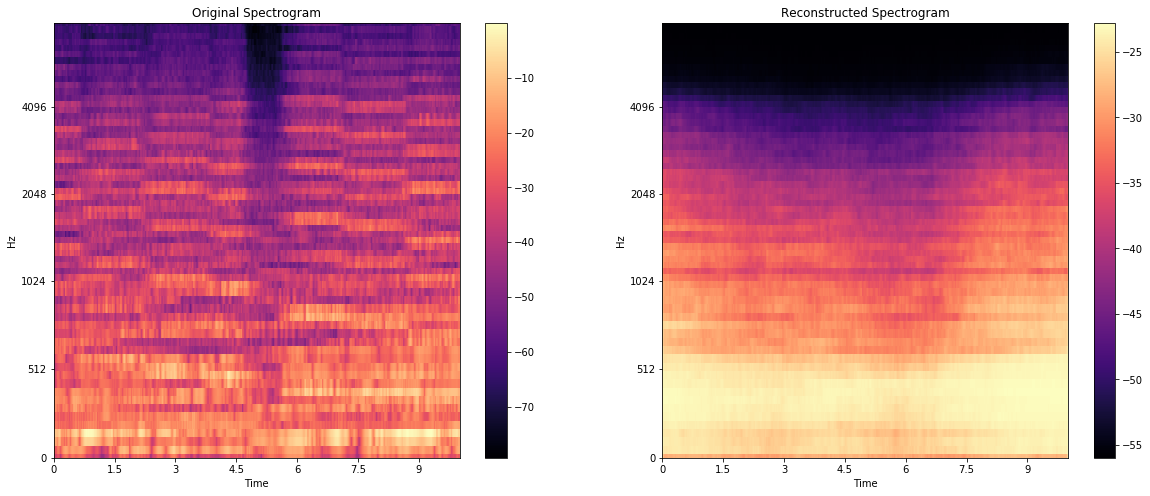

In [43]:
plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
librosa.display.specshow(stft_sd*images[0,:,:].detach().numpy() + stft_mean, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar()
plt.title("Original Spectrogram")
plt.subplot(1,2,2)
librosa.display.specshow(stft_sd*dec_output[0,:,:].detach().numpy()+stft_mean,  x_axis='time',y_axis='mel', sr=sr,fmax=8000)
plt.colorbar()
plt.title("Reconstructed Spectrogram")
pass

In [44]:
CAE_train_features = torch.zeros(1, 40)
for batch_idx, (data, target) in enumerate(train_loader):
    img = data.view(data.shape[0], data.shape[1]*data.shape[2])
    enc_output = model.encoder(img)
    CAE_train_features = torch.cat((CAE_train_features, enc_output), 0)
    
    if batch_idx == 0:
        CAE_train_labels = target
    else:
        CAE_train_labels = torch.cat((CAE_train_labels, target), 0)

In [45]:
CAE_train_features = CAE_train_features[1:, :]
CAE_train_features.shape

torch.Size([1073, 40])

In [46]:
CAE_test_features = torch.zeros(1, 40)

for batch_idx, (data, target) in enumerate(test_loader):
    img = data.view(data.shape[0], data.shape[1]*data.shape[2])
    enc_output = model.encoder(img)
    CAE_test_features = torch.cat((CAE_test_features, enc_output), 0)
    if batch_idx == 0:
        CAE_test_labels = target
    else:
        CAE_test_labels = torch.cat((CAE_test_labels, target), 0)

In [47]:
CAE_test_features = CAE_test_features[1:, :]
CAE_test_features.shape

torch.Size([768, 40])

In [48]:
CAE_train_features = CAE_train_features.detach().numpy()
CAE_test_features = CAE_test_features.detach().numpy()
CAE_train_labels = CAE_train_labels.numpy()
CAE_test_labels = CAE_test_labels.numpy()

In [16]:
## Classify via logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [50]:
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                        max_iter = 5000).fit(X=CAE_train_features, y=CAE_train_labels)

In [51]:
## Training Accuracy
y_pred = clf.predict(CAE_train_features)
CAE_train_acc = metrics.accuracy_score(CAE_train_labels, y_pred)
CAE_train_acc

0.4063373718546132

In [52]:
## Test Accuracy
y_pred = clf.predict(CAE_test_features)
CAE_test_acc = metrics.accuracy_score(CAE_test_labels, y_pred)
CAE_test_acc

0.34375

### PCA

In [6]:
## Load new data
train_stft1 = np.load("Data/train_stft-dB-1.npy", allow_pickle = True)
test_stft1 = np.load("Data/test_stft-dB-1.npy")
train_labels1 = np.load("Data/train_labels_stft-dB-1.npy")
test_labels1 = np.load("Data/test_labels_stft-dB-1.npy")

train_stft2 = np.load("Data/train_stft-dB-2.npy", allow_pickle = True)
test_stft2 = np.load("Data/test_stft-dB-2.npy")
train_labels2 = np.load("Data/train_labels_stft-dB-2.npy")
test_labels2 = np.load("Data/test_labels_stft-dB-2.npy")

train_stft = np.concatenate((train_stft1, train_stft2))
test_stft = np.concatenate((test_stft1, test_stft2))
train_labels_set1 = np.concatenate((train_labels1, train_labels2))
test_labels_set1 = np.concatenate((test_labels1, test_labels2))

In [7]:
X_train = np.reshape(train_stft, (train_stft.shape[0],train_stft.shape[1]*train_stft.shape[2]))
X_train.shape

(2147, 27584)

In [8]:
X_test = np.reshape(test_stft, (test_stft.shape[0],test_stft.shape[1]*test_stft.shape[2]))
X_test.shape

(1538, 27584)

In [9]:
from sklearn.decomposition import PCA
# Fit the PCA model to the training set
pca = PCA(n_components = 40).fit(X_train)

# Encoded training values and test values
encoded_train_pca1 = pca.fit_transform(X_train)
encoded_test_pca1 = pca.fit_transform(X_test)

In [10]:
## Load new data
train_stft1 = np.load("Data/train_stft-dB-3.npy", allow_pickle = True)
test_stft1 = np.load("Data/test_stft-dB-3.npy")
train_labels1 = np.load("Data/train_labels_stft-dB-3.npy")
test_labels1 = np.load("Data/test_labels_stft-dB-3.npy")

train_stft2 = np.load("Data/train_stft-dB-4.npy", allow_pickle = True)
test_stft2 = np.load("Data/test_stft-dB-4.npy")
train_labels2 = np.load("Data/train_labels_stft-dB-4.npy")
test_labels2 = np.load("Data/test_labels_stft-dB-4.npy")

train_stft = np.concatenate((train_stft1, train_stft2))
test_stft = np.concatenate((test_stft1, test_stft2))
train_labels_set2 = np.concatenate((train_labels1, train_labels2))
test_labels_set2 = np.concatenate((test_labels1, test_labels2))

X_train = np.reshape(train_stft, (train_stft.shape[0],train_stft.shape[1]*train_stft.shape[2]))
X_test = np.reshape(test_stft, (test_stft.shape[0],test_stft.shape[1]*test_stft.shape[2]))


# Fit the PCA model to the training set
pca = PCA(n_components = 40).fit(X_train)

# Encoded training values and test values
encoded_train_pca2 = pca.fit_transform(X_train)
encoded_test_pca2 = pca.fit_transform(X_test)

In [11]:
## Load new data
train_stft = np.load("Data/train_stft-dB-5.npy", allow_pickle = True)
test_stft = np.load("Data/test_stft-dB-5.npy")
train_labels_set3 = np.load("Data/train_labels_stft-dB-5.npy")
test_labels_set3 = np.load("Data/test_labels_stft-dB-5.npy")


X_train = np.reshape(train_stft, (train_stft.shape[0],train_stft.shape[1]*train_stft.shape[2]))
X_test = np.reshape(test_stft, (test_stft.shape[0],test_stft.shape[1]*test_stft.shape[2]))


# Fit the PCA model to the training set
pca = PCA(n_components = 40).fit(X_train)

# Encoded training values and test values
encoded_train_pca3 = pca.fit_transform(X_train)
encoded_test_pca3 = pca.fit_transform(X_test)

In [13]:
train_pca = np.concatenate((encoded_train_pca1, encoded_train_pca2, encoded_train_pca3))
test_pca = np.concatenate((encoded_test_pca1, encoded_test_pca2, encoded_test_pca3))

In [14]:
train_labels = np.concatenate((train_labels_set1, train_labels_set2, train_labels_set3))
test_labels = np.concatenate((test_labels_set1, test_labels_set2, test_labels_set3))

In [17]:
## Logistic Regression
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                    max_iter = 1000).fit(X=train_pca, y=train_labels)

## Training Accuracy
y_pred = clf.predict(train_pca)
metrics.accuracy_score(train_labels, y_pred)

0.45956019381289603

In [18]:
## Test Accuracy
y_pred = clf.predict(test_pca)
metrics.accuracy_score(test_labels, y_pred)

0.28240499739718894